# Housekeeping

In [ ]:
!pip install itables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance


from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

from google.colab import drive
drive.mount('/content/drive')
drive_dir = '/content/drive/MyDrive/Spring 2025/Data Science/Projects/Project 3: Car Prices Data/Data/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
df = pd.read_csv('/content/drive/MyDrive/Copy of Final_Data.csv')

<ipython-input-13-bf98dca99d92>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Copy of Final_Data.csv')


# Fix data discrepancies

In [14]:
#drop vin column - useless column
df = df.drop(['vin' , 'dealer_zip'], axis= 1)

In [15]:
df['years_old'] = df['years_old'] + 1 # fix mistake from original WHOOPS

In [16]:
#fix inifinities
df.loc[(df['savings_amount'] == 0) | (df['years_old'] == 0), 'yearly_depreciation'] = 0
df.loc[(df['savings_amount'] != 0) & (df['years_old'] != 0), 'yearly_depreciation'] = df['savings_amount'] / df['years_old']

In [17]:
#sanity check
df['yearly_depreciation'].describe()

count    206401.000000
mean        323.000329
std         555.490443
min           0.000000
25%          55.000000
50%         162.100000
75%         378.000000
max       31364.000000
Name: yearly_depreciation, dtype: float64

In [18]:
#fixing mileage depreciation per mile values
df.loc[(df['savings_amount'] == 0) | (df['mileage'] == 0), 'depreciation_per_mile'] = 0
df.loc[(df['savings_amount'] != 0) & (df['mileage'] != 0), 'depreciation_per_mile'] = df['savings_amount'] / df['mileage']

In [19]:
#sanity check for depreciation_per_mile column
df['depreciation_per_mile'].describe()

count    206401.000000
mean          0.063791
std           0.427034
min           0.000000
25%           0.005387
50%           0.017033
75%           0.044678
max          56.291803
Name: depreciation_per_mile, dtype: float64

In [32]:
# map top 20 makes to price range group
make_to_group = {
    'Mercedes-Benz': 'High End',
    'BMW': 'High End',
    'RAM': 'High End',
    'Audi': 'High End',
    'Cadillac': 'High End',

    'Lexus': 'Upper-Mid',
    'GMC': 'Upper-Mid',
    'Ford': 'Upper-Mid',
    'Jeep': 'Upper-Mid',
    'Dodge': 'Upper-Mid',

    'Chevrolet': 'Mid',
    'Toyota': 'Mid',
    'Subaru': 'Mid',
    'Buick': 'Mid',
    'Mazda': 'Mid',

    'Honda': 'Affordable',
    'Nissan': 'Affordable',
    'Volkswagon': 'Affordable',
    'Kia': 'Affordable',
    'Hyundai': 'Affordable'
}

df['price_group'] = df['make_name'].map(make_to_group)

# Data Exploration

What are the most common car makes?

In [33]:
df['price_group'].value_counts()
# more cars in mid and upper-mid

price_group
Mid           55375
Upper-Mid     53853
Affordable    45145
High End      26743
Name: count, dtype: int64

In [20]:
df['make_name'].value_counts()

make_name
Ford             24378
Chevrolet        22770
Toyota           16454
Nissan           16188
Honda            14234
Jeep             13586
Subaru            8905
Hyundai           8487
BMW               8308
Mercedes-Benz     7027
GMC               6697
Kia               6237
Dodge             5918
Volkswagen        5386
Audi              4604
Mazda             3865
RAM               3554
Buick             3382
Lexus             3280
Cadillac          3275
INFINITI          2945
Chrysler          2917
Acura             2911
Lincoln           2695
Volvo             1963
Land Rover        1492
MINI               818
Mitsubishi         817
Jaguar             702
Porsche            575
FIAT               249
Maserati           222
Pontiac            217
Alfa Romeo         204
Scion              176
Genesis            170
Saturn             166
Mercury            148
Bentley            123
Hummer              90
Saab                85
Suzuki              50
Rolls-Royce         47
smart               31
Oldsmobile          13
Ferrari             12
Plymouth             7
Aston Martin         7
Isuzu                6
Fisker               2
Lotus                2
Karma                2
Lamborghini          2
Name: count, dtype: int64

How old are cars generally?

In [21]:
df['years_old'].describe()

count    206401.000000
mean          5.013125
std           3.413199
min           0.000000
25%           3.000000
50%           4.000000
75%           6.000000
max          35.000000
Name: years_old, dtype: float64

How about mileage?

In [22]:
df['mileage'].describe()

count    206401.000000
mean      50446.865073
std       41155.868950
min           0.000000
25%       22532.000000
50%       36973.000000
75%       70214.000000
max      374485.000000
Name: mileage, dtype: float64

What are the average prices of used cars?

In [23]:
df['price'].describe()

count    2.064010e+05
mean     2.293834e+04
std      1.473796e+04
min      4.000000e+02
25%      1.474400e+04
50%      1.999900e+04
75%      2.899000e+04
max      2.698500e+06
Name: price, dtype: float64

How many days do cars generally sit on the market?

In [24]:
df['daysonmarket'].describe()

count    206401.000000
mean         55.932181
std          92.482627
min           0.000000
25%          13.000000
50%          29.000000
75%          56.000000
max        2497.000000
Name: daysonmarket, dtype: float64

What are the most popular body types of cars?

In [25]:
df['body_type'].value_counts()

body_type
SUV / Crossover    99578
Sedan              62082
Pickup Truck       18913
Hatchback           5782
Minivan             5672
Coupe               4916
Wagon               4854
Van                 2493
Convertible         2111
Name: count, dtype: int64

# Filtering out our data

Since the top 20 car makes take up 90% of our df, we will filter for the top 20

In [26]:
#filter for only the top 20 car makes
top_20_makes = df['make_name'].value_counts().head(20).index  # Get top 20 car makes
df = df[df['make_name'].isin(top_20_makes)]  # Filter original DataFrame

In [27]:
len(df)

186535

In [28]:
df.head()

body_type  daysonmarket  engine_displacement engine_type  fleet  \
2            Sedan            33               1600.0          I4  False   
3            Sedan            55               1500.0          I4   True   
4            Coupe            36               3500.0          V6  False   
5  SUV / Crossover            27               3600.0          V6  False   
6  SUV / Crossover            27               3600.0          V6  False   

   frame_damaged  franchise_dealer  front_legroom  fuel_tank_volume fuel_type  \
2          False              True           42.2              14.0  Gasoline   
3          False              True           42.0              15.8  Gasoline   
4          False              True           45.4              17.4  Gasoline   
5          False              True           41.0              19.4  Gasoline   
6          False              True           41.3              22.0  Gasoline   

   ...  transmission  wheel_system_display  wheelbase width  year  years_old  \
2  ...             A     Front-Wheel Drive      106.3  70.9  2017          4   
3  ...             A     Front-Wheel Drive      111.4  73.0  2018          3   
4  ...             A       All-Wheel Drive      107.5  81.5  2018          3   
5  ...             A     Front-Wheel Drive      120.9  78.6  2018          3   
6  ...             A       All-Wheel Drive      118.9  78.5  2017          4   

  option_count original_price  yearly_depreciation  depreciation_per_mile  
2         12.0        16033.0           677.250000               0.088221  
3         14.0        16388.0           583.000000               0.041256  
4          7.0        33861.0           620.333333               0.029895  
5         15.0        27223.0          1166.666667               0.096127  
6         17.0        24838.0           604.000000               0.067009  

[5 rows x 37 columns]

In [31]:
df['make_name'].unique()

array(['Hyundai', 'Chevrolet', 'Lexus', 'Jeep', 'Cadillac', 'Dodge',
       'Mercedes-Benz', 'Nissan', 'Honda', 'Kia', 'Ford', 'Subaru', 'BMW',
       'Audi', 'Volkswagen', 'Mazda', 'Toyota', 'GMC', 'RAM', 'Buick'],
      dtype=object)

Filter out any price outliers

In [29]:
df = df[df['price'] < 150001]

In [30]:
df['price'].describe()

count    186502.000000
mean      22382.548257
std       11752.964849
min         400.000000
25%       14700.000000
50%       19968.000000
75%       28488.000000
max      150000.000000
Name: price, dtype: float64

# Label Encoding

In [34]:
df.head()

body_type  daysonmarket  engine_displacement engine_type  fleet  \
2            Sedan            33               1600.0          I4  False   
3            Sedan            55               1500.0          I4   True   
4            Coupe            36               3500.0          V6  False   
5  SUV / Crossover            27               3600.0          V6  False   
6  SUV / Crossover            27               3600.0          V6  False   

   frame_damaged  franchise_dealer  front_legroom  fuel_tank_volume fuel_type  \
2          False              True           42.2              14.0  Gasoline   
3          False              True           42.0              15.8  Gasoline   
4          False              True           45.4              17.4  Gasoline   
5          False              True           41.0              19.4  Gasoline   
6          False              True           41.3              22.0  Gasoline   

   ...  wheel_system_display  wheelbase  width  year  years_old  option_count  \
2  ...     Front-Wheel Drive      106.3   70.9  2017          4          12.0   
3  ...     Front-Wheel Drive      111.4   73.0  2018          3          14.0   
4  ...       All-Wheel Drive      107.5   81.5  2018          3           7.0   
5  ...     Front-Wheel Drive      120.9   78.6  2018          3          15.0   
6  ...       All-Wheel Drive      118.9   78.5  2017          4          17.0   

  original_price yearly_depreciation  depreciation_per_mile  price_group  
2        16033.0          677.250000               0.088221   Affordable  
3        16388.0          583.000000               0.041256          Mid  
4        33861.0          620.333333               0.029895    Upper-Mid  
5        27223.0         1166.666667               0.096127          Mid  
6        24838.0          604.000000               0.067009          Mid  

[5 rows x 38 columns]

In [35]:
#check the difference between original_price and price
df[['price', 'original_price']]

price  original_price
2       13324.0         16033.0
3       14639.0         16388.0
4       32000.0         33861.0
5       23723.0         27223.0
6       22422.0         24838.0
...         ...             ...
206395  14495.0         14984.0
206396  16495.0         17298.0
206397   4550.0          4550.0
206398  22495.0         24553.0
206399  32080.0         32110.0

[186502 rows x 2 columns]

In [36]:
df.dtypes

body_type                 object
daysonmarket               int64
engine_displacement      float64
engine_type               object
fleet                       bool
frame_damaged               bool
franchise_dealer            bool
front_legroom            float64
fuel_tank_volume         float64
fuel_type                 object
has_accidents               bool
height                   float64
horsepower               float64
interior_color            object
iscab                       bool
length                   float64
listing_color             object
make_name                 object
maximum_seating          float64
mileage                  float64
model_name                object
owner_count              float64
price                    float64
salvage                     bool
savings_amount             int64
sp_name                   object
theft_title                 bool
transmission              object
wheel_system_display      object
wheelbase                float64
width                    float64
year                       int64
years_old                  int64
option_count             float64
original_price           float64
yearly_depreciation      float64
depreciation_per_mile    float64
price_group               object
dtype: object

In [37]:
df.head()

body_type  daysonmarket  engine_displacement engine_type  fleet  \
2            Sedan            33               1600.0          I4  False   
3            Sedan            55               1500.0          I4   True   
4            Coupe            36               3500.0          V6  False   
5  SUV / Crossover            27               3600.0          V6  False   
6  SUV / Crossover            27               3600.0          V6  False   

   frame_damaged  franchise_dealer  front_legroom  fuel_tank_volume fuel_type  \
2          False              True           42.2              14.0  Gasoline   
3          False              True           42.0              15.8  Gasoline   
4          False              True           45.4              17.4  Gasoline   
5          False              True           41.0              19.4  Gasoline   
6          False              True           41.3              22.0  Gasoline   

   ...  wheel_system_display  wheelbase  width  year  years_old  option_count  \
2  ...     Front-Wheel Drive      106.3   70.9  2017          4          12.0   
3  ...     Front-Wheel Drive      111.4   73.0  2018          3          14.0   
4  ...       All-Wheel Drive      107.5   81.5  2018          3           7.0   
5  ...     Front-Wheel Drive      120.9   78.6  2018          3          15.0   
6  ...       All-Wheel Drive      118.9   78.5  2017          4          17.0   

  original_price yearly_depreciation  depreciation_per_mile  price_group  
2        16033.0          677.250000               0.088221   Affordable  
3        16388.0          583.000000               0.041256          Mid  
4        33861.0          620.333333               0.029895    Upper-Mid  
5        27223.0         1166.666667               0.096127          Mid  
6        24838.0          604.000000               0.067009          Mid  

[5 rows x 38 columns]

In [38]:
df.columns

Index(['body_type', 'daysonmarket', 'engine_displacement', 'engine_type',
       'fleet', 'frame_damaged', 'franchise_dealer', 'front_legroom',
       'fuel_tank_volume', 'fuel_type', 'has_accidents', 'height',
       'horsepower', 'interior_color', 'iscab', 'length', 'listing_color',
       'make_name', 'maximum_seating', 'mileage', 'model_name', 'owner_count',
       'price', 'salvage', 'savings_amount', 'sp_name', 'theft_title',
       'transmission', 'wheel_system_display', 'wheelbase', 'width', 'year',
       'years_old', 'option_count', 'original_price', 'yearly_depreciation',
       'depreciation_per_mile', 'price_group'],
      dtype='object')

In [39]:
#list categorical columns

cat_cols = ['body_type', 'engine_type', 'fleet', 'frame_damaged', 'franchise_dealer',
            'fuel_type', 'has_accidents', 'interior_color', 'iscab', 'listing_color', 'make_name',
            'model_name', 'salvage',  'sp_name', 'theft_title', 'transmission','wheel_system_display']

label_encoder = {}

#create for loop to go through each categorical column

for c in cat_cols:
  #create a new label encoder for each column
  le = LabelEncoder()

  #fit the label encoder on the column data
  le.fit(df[c])

  #transform the column to numeric
  df[c] = le.transform(df[c])

  #save label encoder to label_encoder dictionary, indexed by the column
  label_encoder[c] = le

df.head()

body_type  daysonmarket  engine_displacement  engine_type  fleet  \
2          6            33               1600.0            5      0   
3          6            55               1500.0            5      1   
4          1            36               3500.0           18      0   
5          5            27               3600.0           18      0   
6          5            27               3600.0           18      0   

   frame_damaged  franchise_dealer  front_legroom  fuel_tank_volume  \
2              0                 1           42.2              14.0   
3              0                 1           42.0              15.8   
4              0                 1           45.4              17.4   
5              0                 1           41.0              19.4   
6              0                 1           41.3              22.0   

   fuel_type  ...  wheel_system_display  wheelbase  width  year  years_old  \
2          4  ...                     3      106.3   70.9  2017          4   
3          4  ...                     3      111.4   73.0  2018          3   
4          4  ...                     1      107.5   81.5  2018          3   
5          4  ...                     3      120.9   78.6  2018          3   
6          4  ...                     1      118.9   78.5  2017          4   

   option_count  original_price  yearly_depreciation  depreciation_per_mile  \
2          12.0         16033.0           677.250000               0.088221   
3          14.0         16388.0           583.000000               0.041256   
4           7.0         33861.0           620.333333               0.029895   
5          15.0         27223.0          1166.666667               0.096127   
6          17.0         24838.0           604.000000               0.067009   

   price_group  
2   Affordable  
3          Mid  
4    Upper-Mid  
5          Mid  
6          Mid  

[5 rows x 38 columns]

# KNN - Modeling (Prices)

In [40]:
df['make_name'].value_counts() # how many of each make is there?

make_name
6     24373
4     22770
18    16454
15    16187
8     14234
10    13586
17     8904
9      8487
1      8307
14     7006
7      6697
11     6237
5      5917
19     5386
0      4602
13     3865
16     3553
2      3382
12     3280
3      3275
Name: count, dtype: int64

In [41]:
# #split data: train - 70%, test - 30%, stratify to leverage difference in number of car makes
train_df, test_df = train_test_split(df, train_size = .7 , test_size = .3, stratify = df['make_name'])
X_train = train_df[['body_type', 'engine_displacement',
       'engine_type', 'fleet', 'frame_damaged', 'franchise_dealer',
       'front_legroom', 'fuel_tank_volume', 'fuel_type', 'has_accidents',
       'height', 'horsepower', 'interior_color', 'iscab', 'length',
       'listing_color', 'make_name', 'maximum_seating', 'mileage',
       'model_name', 'owner_count', 'salvage',
       'sp_name', 'theft_title', 'transmission', 'wheel_system_display',
       'wheelbase', 'width', 'years_old', 'option_count']]
y_train = train_df['price']

X_test = test_df[['body_type', 'engine_displacement',
       'engine_type', 'fleet', 'frame_damaged', 'franchise_dealer',
       'front_legroom', 'fuel_tank_volume', 'fuel_type', 'has_accidents',
       'height', 'horsepower', 'interior_color', 'iscab', 'length',
       'listing_color', 'make_name', 'maximum_seating', 'mileage',
       'model_name', 'owner_count', 'salvage',
       'sp_name', 'theft_title', 'transmission', 'wheel_system_display',
       'wheelbase', 'width', 'years_old', 'option_count']]
y_test = test_df['price']

# #all columns except we didn't include savings_amount and year column

In [42]:
#we need to scale our data again since we dropped data
scaler = StandardScaler()

#fit and transform train dataset
X_train_scaled = scaler.fit_transform(X_train)

#fit and transform test dataset
X_test_scaled = scaler.fit_transform(X_test)

In [44]:
#define hyperparameter grid
param_grid = {
    'n_neighbors': range(1,21,2), # from 1 - 20 skip by 2 each time
    'weights': ['distance', 'uniform'],
}

In [45]:
grid_search = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=param_grid)

grid_search.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 21, 2),
                         'weights': ['distance', 'uniform']})

In [46]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'n_neighbors': 5, 'weights': 'distance'}


In [43]:
#call in KNN Regressor because we have both categorical and continuous variables
knn_regr = KNeighborsRegressor(n_neighbors = 5, weights = 'distance')

#fit the model
knn_regr.fit(X_train_scaled , y_train)

#predict
knn_regr_preds = knn_regr.predict(X_test_scaled)

In [47]:
# check metrics within each make name's pred and actual
test_df['knn_regr_pred'] = knn_regr_preds

for make in test_df['make_name'].unique():
  make_test_df = test_df[test_df['make_name'] == make]

  make_knn_regr_preds = make_test_df['knn_regr_pred']
  make_y_test = make_test_df['price']

  MAE = mean_absolute_error(make_y_test, make_knn_regr_preds) #measures the absolute difference between our predictions and the real y values (car prices)
  MSE = mean_squared_error(make_y_test , make_knn_regr_preds) #^^ same thing but squared
  R2 = r2_score(make_y_test , make_knn_regr_preds)

  print(make)
  print(f"mean_absolute_error: {MAE}")
  print(f"mean_squared_error:{MSE}")
  print(f"R^2: {R2}")
  print('='*20)

15
mean_absolute_error: 1667.3051857421708
mean_squared_error:5440765.463868291
R^2: 0.8834445785216332
8
mean_absolute_error: 1606.9070318422703
mean_squared_error:6424967.100936473
R^2: 0.8701833069829726
10
mean_absolute_error: 2197.7054350222256
mean_squared_error:10393180.632642094
R^2: 0.8856604718169206
7
mean_absolute_error: 2461.707084500761
mean_squared_error:11393435.317376357
R^2: 0.9243099977166597
17
mean_absolute_error: 1680.0149081790776
mean_squared_error:5190768.61951233
R^2: 0.8940186999841763
11
mean_absolute_error: 1656.3018121760804
mean_squared_error:5009202.482888157
R^2: 0.8512865417386837
2
mean_absolute_error: 1914.0481136600235
mean_squared_error:7375884.197907004
R^2: 0.8618727913193253
18
mean_absolute_error: 1829.5247006326729
mean_squared_error:6824533.051258743
R^2: 0.9134249237571365
5
mean_absolute_error: 2560.2087646498394
mean_squared_error:16474904.809703017
R^2: 0.8694459282482041
1
mean_absolute_error: 3980.8708010995388
mean_squared_error:360582

In [48]:
#these are our regression metrics

MAE = mean_absolute_error(y_test, knn_regr_preds) #measures the absolute difference between our predictions and the real y values (car prices)
MSE = mean_squared_error(y_test , knn_regr_preds) #^^ same thing but squared
R2 = r2_score(y_test , knn_regr_preds)

print(f"mean_absolute_error: {MAE}")
print(f"mean_squared_error:{MSE}")
print(f"R^2: {R2}")

mean_absolute_error: 2256.257945388623
mean_squared_error:12564043.45371719
R^2: 0.9085840484688256


Text(0, 0.5, 'Predictions')

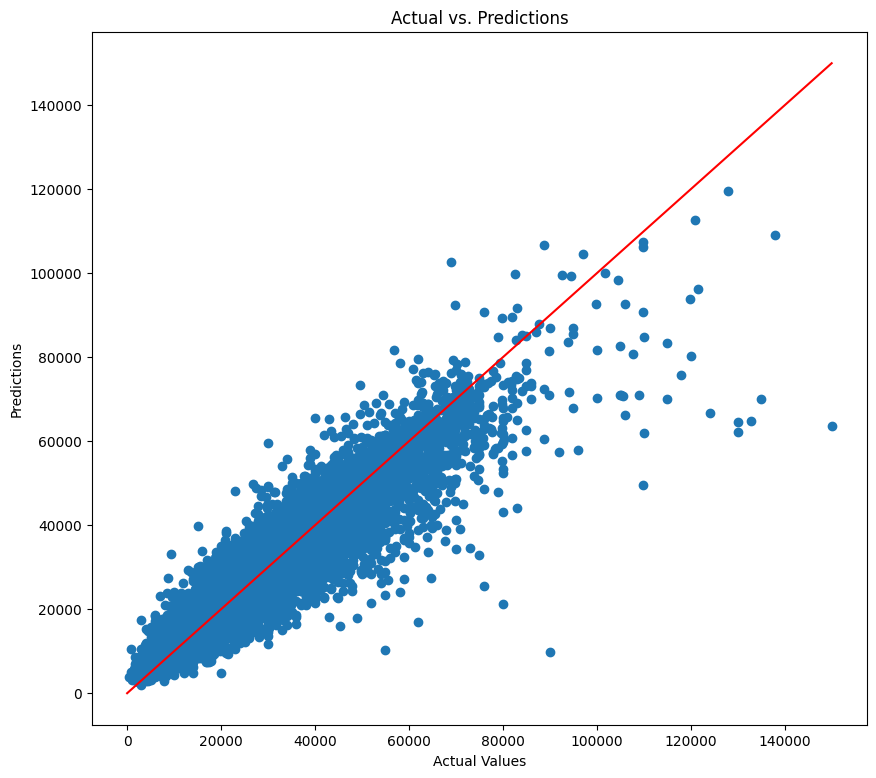

In [49]:
#let's check our results again.

plt.figure(figsize = (10, 9))
plt.scatter(y_test , knn_regr_preds)
plt.title('Actual vs. Predictions')
plt.plot([0, 150000], [0, 150000], color = 'red')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')

In [52]:
# find predictions with the highest errors
test_df['abs_error'] = abs(test_df['price'] - test_df['knn_regr_pred'])
high_error_df = test_df.sort_values(by='abs_error', ascending=False)

In [54]:
high_error_df.head()

body_type  daysonmarket  engine_displacement  engine_type  fleet  \
129172          6             2               6000.0           17      0   
8272            6             7               2400.0            5      0   
205508          6           315               4000.0           23      0   
130627          1            85               6200.0           23      0   
140897          6            45               6000.0           17      0   

        frame_damaged  franchise_dealer  front_legroom  fuel_tank_volume  \
129172              0                 1           41.4              24.6   
8272                0                 1           42.5              18.5   
205508              0                 1           41.4              21.1   
130627              0                 1           42.8              18.5   
140897              0                 1           41.4              24.6   

        fuel_type  ...  width  year  years_old  option_count  original_price  \
129172          4  ...   83.9  2018          3           9.0        154971.0   
8272            4  ...   72.7  2012          9           3.0         89995.0   
205508          4  ...   83.9  2020          1           9.0        151874.0   
130627          4  ...   76.1  2020          1          12.0        139620.0   
140897          4  ...   83.9  2017          4          11.0        129990.0   

        yearly_depreciation  depreciation_per_mile  price_group  \
129172               1657.0               0.310843     High End   
8272                    0.0               0.000000   Affordable   
205508              18974.0               5.704750     High End   
130627               9621.0               5.590354          Mid   
140897                  0.0               0.000000     High End   

        knn_regr_pred     abs_error  
129172   63675.641822  86324.358178  
8272      9893.261831  80101.738169  
205508   64723.576648  68176.423352  
130627   62256.799213  67742.200787  
140897   64648.355419  65341.644581  

[5 rows x 40 columns]

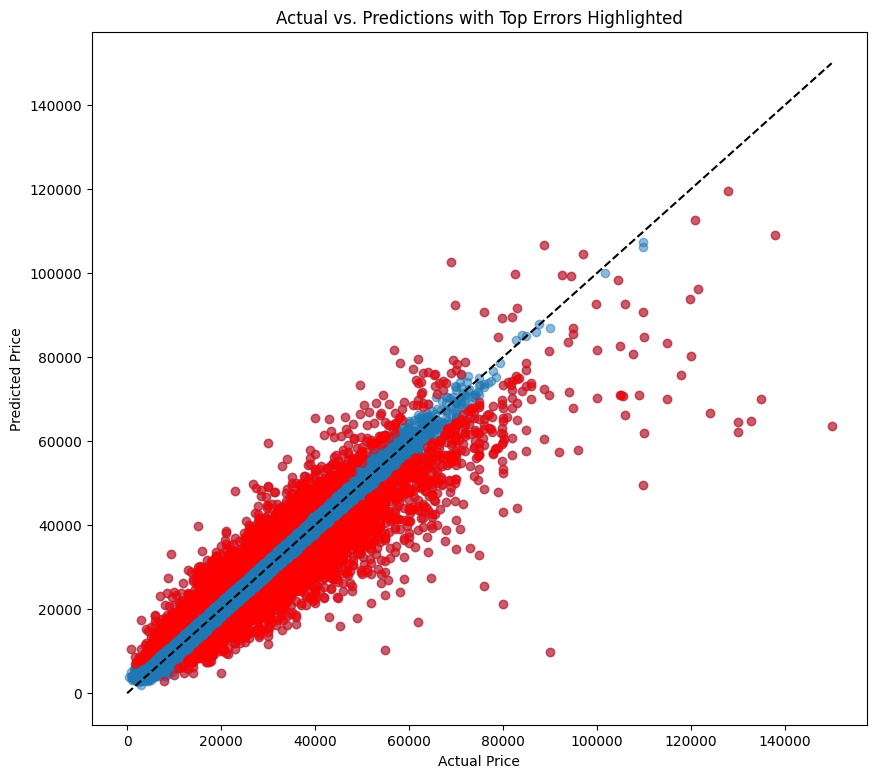

In [56]:
plt.figure(figsize=(10, 9))

# Plot all points
plt.scatter(y_test, knn_regr_preds, alpha=0.5, label='All Points')

# Highlight top 50 highest errors
top_errors = high_error_df.head(5500)
plt.scatter(top_errors['price'], top_errors['knn_regr_pred'], alpha=0.5, color='red', label='Top Errors')

# 45-degree line
plt.plot([0, 150000], [0, 150000], color='black', linestyle='--')

plt.title('Actual vs. Predictions with Top Errors Highlighted')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

## Characteristics of highest errors

Within the top errors, what are the price ranges with the most errors?

In [69]:
top_errors['price_group'].value_counts() / test_df['price_group'].value_counts()

price_group
Affordable    0.038913
High End      0.238315
Mid           0.065792
Upper-Mid     0.116242
Name: count, dtype: float64

Within each make name, what are the makes that have the highest percentage of errors?

In [58]:
top_errors['make_name'].value_counts() / test_df['make_name'].value_counts() * 100

make_name
0     25.126720
1     26.243981
2      6.995074
3     20.162933
4      8.432148
5     11.661972
6     12.158096
7     11.796914
8      3.770492
9      2.906520
10     8.660451
11     3.474078
12    19.512195
13     4.396552
14    24.785918
15     4.674629
16    18.011257
17     4.155747
18     5.753647
19     5.569307
Name: count, dtype: float64

Within each body type, what are the types that have the highest percentage of errors?

In [59]:
top_errors['body_type'].value_counts() / test_df['body_type'].value_counts() * 100

body_type
0    34.873950
1    27.169505
2     5.009759
3    10.125523
4    18.529514
5     8.895649
6     7.174275
7     9.587217
8     5.031949
Name: count, dtype: float64

# Apply model 1 to df

In [60]:
# put entire df back into model for predicted price
X = df[['body_type', 'engine_displacement',
       'engine_type', 'fleet', 'frame_damaged', 'franchise_dealer',
       'front_legroom', 'fuel_tank_volume', 'fuel_type', 'has_accidents',
       'height', 'horsepower', 'interior_color', 'iscab', 'length',
       'listing_color', 'make_name', 'maximum_seating', 'mileage',
       'model_name', 'owner_count', 'salvage',
       'sp_name', 'theft_title', 'transmission', 'wheel_system_display',
       'wheelbase', 'width', 'years_old', 'option_count']]
y = df['price']
df['predicted_price'] = knn_regr.predict(X)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


In [61]:
# calculate the price difference and make a new column
# + price difference = deal (car selling at a cheaper price than the market (predicted) price)
# - price difference = overcharging (car selling at a higher price than the market (predicted) price)
df['price_difference'] = df['predicted_price'] - df['price']

Is there a relationship between the price difference and days on market?

Text(0, 0.5, 'Price difference (Predicted - Actual)')

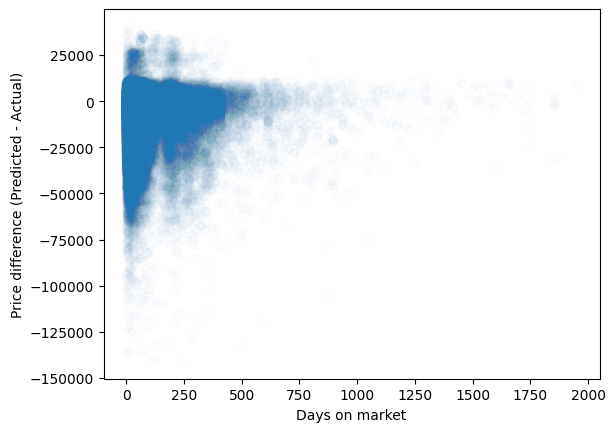

In [63]:
plt.scatter(df['daysonmarket'], df['price_difference'], alpha = 0.01)
plt.xlabel('Days on market')
plt.ylabel('Price difference (Predicted - Actual)')

No

Is there a relationship between the price difference and the mileage?

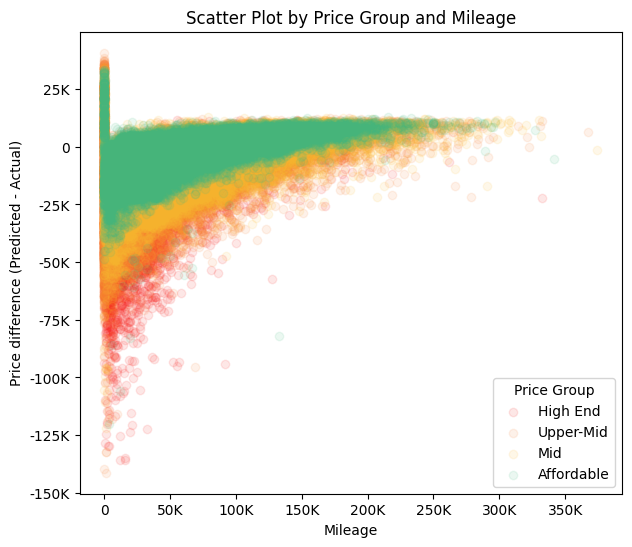

In [66]:
from matplotlib.ticker import FuncFormatter

# Define your custom color map
price_group_colors = {
    'High End': '#F51611',
    'Upper-Mid': '#F67C30',
    'Mid': '#FEB92D',
    'Affordable': '#41BB7F'
}

def format_thousands(x, pos):
    abs_x = abs(x)
    if abs_x >= 1_000_000:
        return f'{x/1_000_000:.0f}M'
    elif abs_x >= 1_000:
        return f'{x/1_000:.0f}K'
    else:
        return f'{x:.0f}'

plt.figure(figsize=(7, 6))

# plot all price groups
for group, color in price_group_colors.items():
    subset = df[df['price_group'] == group]
    plt.scatter(
        subset['mileage'],
        subset['price_difference'],
        label=group,
        color=color,
        alpha=0.1
    )

plt.xlabel('Mileage')
plt.ylabel('Price difference (Predicted - Actual)')
plt.title('Scatter Plot by Price Group and Mileage')
plt.legend(title='Price Group')

# abbreviate x and y axis numbers
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_thousands))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_thousands))

# transparent background
plt.gca().patch.set_alpha(0)
plt.gcf().patch.set_alpha(0)

plt.show()

What is the relationship between the price difference and the age of the car based by each price group?

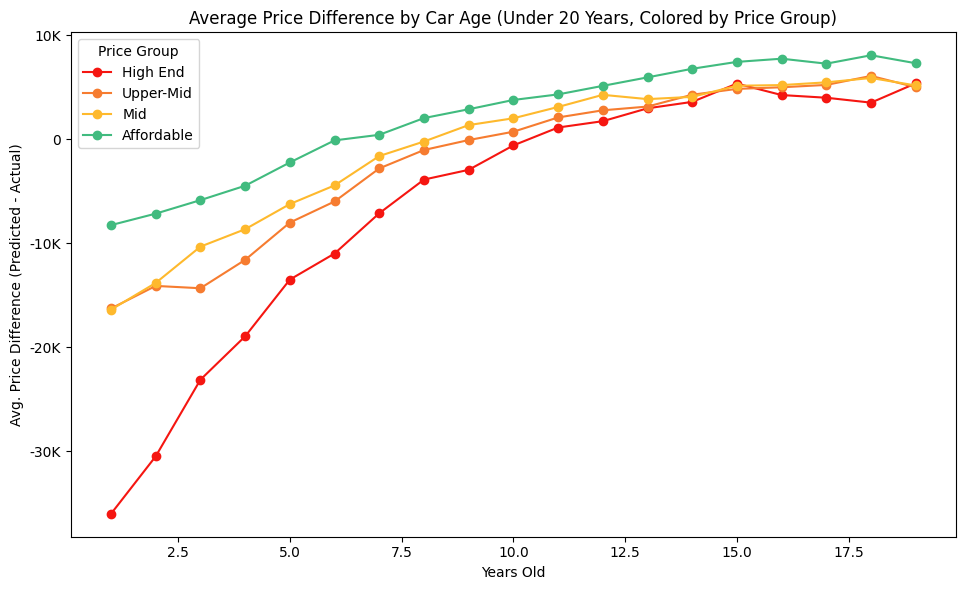

In [67]:
# Filter the DataFrame
filtered_df = df[(df['years_old'] > 0) & (df['years_old'] < 20) ]

# group by both years_old and price_group
grouped = filtered_df.groupby(['years_old', 'price_group'])['price_difference'].mean().unstack()

# plot each price group as a separate line
plt.figure(figsize=(10, 6))

for group, color in price_group_colors.items():
    if group in grouped.columns:
        plt.plot(grouped.index, grouped[group], marker='o', label=group, color=color)

plt.title('Average Price Difference by Car Age (Under 20 Years, Colored by Price Group)')
plt.xlabel('Years Old')
plt.ylabel('Avg. Price Difference (Predicted - Actual)')
plt.legend(title='Price Group')
plt.tight_layout()

# abbreviate x and y axis numbers
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_thousands))

# transparent background
plt.gca().patch.set_alpha(0)
plt.gcf().patch.set_alpha(0)

plt.show()